# Pipeline for vehicle detection in video
--CLASSIFIER TRAINING
1. Choose features to extract from train images
2. Transform each training image into feature vector
3. Use these labeled feature vectors to train classifier

--TRACKING PIPELINE
1. Slice image into boxes using sliding window
2. Run each window frame through classifier to get car prediction
3. Save position of positive detections
4. Use heatmap to merge duplicates and remove false positives

In [2]:
# import statements
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm 
import imageio
import time
imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Feature Extraction Functions

In [32]:
def explore_dataset(car_images, noncar_images, extract_time, vector_length, X_train, X_test):
    data_dict = {}
    data_dict['num_cars'] = len(car_images)
    data_dict['num_noncars'] = len(noncar_images)
    data_dict['num_features'] = vector_length
    example_image = cv2.imread(car_images[0])
    data_dict['image_shape'] = example_image.shape
    data_dict['data_type'] = example_image.dtype
    data_dict['extract_time'] = extract_time
    data_dict['image_minmax'] = (np.min(example_image), np.max(example_image))
    data_dict['training_size'] = len(X_train)
    data_dict['testing_size'] = len(X_test)
    return data_dict

In [4]:
# draw boxes after corners are detected
# boxes = [((corner1), (corner2)), ((corner1), (corner2)), ((corner1), (corner2))]
# corners = (x,y)
def draw_boxes(img, boxes, color=(0,0,255), thick=6):
    # make copy of image
    draw_image = np.copy(img)
    # draw each box in boxes list
    for box in boxes:
        cv2.rectangle(draw_image, box[0], box[1], color, thick)
    return draw_image


In [5]:
# assumes cv2 or BGR conversion
def convert_color(img, convert='RGB'):
    if convert == 'RGB':
        convert_image =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif convert == 'HSV':
        convert_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif convert == 'LUV':
        convert_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif convert == 'HLS':
        convert_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif convert == 'YUV':
        convert_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif convert == 'YCrCb':
        convert_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        
    return convert_image

In [6]:
# find histograms of each color channel
# returns vector length = nbins*3
def color_hist(img, nbins=32):
    # find histograms of each color channel
    channel1 = np.histogram(img[:,:,0], nbins)
    channel2 = np.histogram(img[:,:,1], nbins)
    channel3 = np.histogram(img[:,:,2], nbins)
    # concatenate into single feature vector
    hist_features = np.concatenate((channel1[0], channel2[0], channel3[0]))
    
#     # VISUALIZATION ##
#     # calculate bin centers based on nbins and bins_range parameters
#     bin_edges = channel1[1]
#     bin_centers = (bin_edges[1:] + bin_edges[:len(bin_edges)-1]) / 2
#     return channel1, channel2, channel3, bin_centers, hist_features
    
    return hist_features

In [7]:
# subsamples image for color and spatial information
# returns vector length = (image_area) * 3
def bin_spatial(img, size=(32,32)):
    # resize image and transform to vector
    bin_spatial_features = cv2.resize(img, size).ravel()
    return bin_spatial_features

In [8]:
# adds gradient vector to add structural information to the classifier
# accepts single color channel or grayscale
# returns vector length = nxblocks * nyblocks * blocksize (cell**2) * orient 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # return list of [hog_features, hog_image]
    return_values = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                       cells_per_block=(cell_per_block,cell_per_block), visualize=True, feature_vector=feature_vec, \
                       block_norm="L2-Hys")
    
    hog_features = return_values[0]
    hog_image = return_values[1]
    
    # returns visualization image if specified
    if vis:
        return hog_features, hog_image
    else:
        return hog_features

In [9]:
# Extracts all feature information from list of images
# Use for training set
# inputs list of image paths plus parameters

def extract_features(img_list, orient, pix_per_cell, cell_per_block, color_space='RGB',\
                     nbins=32, spatial_size=(32,32), feature_vec=True, hog_channel='GRAY',\
                     hist_feat=True, spatial_feat=True, hog_feat=True):

    # create features list, append vector for each image
    features_list = []
    for image in img_list:
        # list to save selected features for each image
        img_features = []
        # read in image using cv2 = BGR
        img = cv2.imread(image)
        # convert to selected colorspace
        feature_image = convert_color(img, color_space)
        
        # create color histogram features
        if hist_feat:
            hist_vector = color_hist(feature_image, nbins)
            img_features.append(hist_vector)
        # create spatial binned features
        if spatial_feat:
            spatial_vector = bin_spatial(feature_image, spatial_size)
            img_features.append(spatial_vector)
        # create hog features
        if hog_feat:
            # selected which channels of image to run hog features on (ALL, GRAY, 0, 1, or 2)
            if hog_channel == 'GRAY':
                gray = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
                hog_vector = get_hog_features(gray, orient, pix_per_cell, cell_per_block, feature_vec=feature_vec)
            elif hog_channel == 'ALL':
                hog_vector = []
                for channel in range(feature_image.shape[2]):
                    hog_vector.extend(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block,\
                                                      feature_vec=feature_vec))
            else:
                hog_vector = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block,\
                                             feature_vec=feature_vec)
            img_features.append(hog_vector)
        
        # add feature vector for each image
        features_list.append(np.concatenate(img_features))
    return features_list

In [10]:
# Use this function to extract all feature vectors from single image
# Use in slide windows
# inputs single image plus parameters

def single_image_features(image, orient, pix_per_cell, cell_per_block, color_space='RGB',\
                     nbins=32, spatial_size=(32,32), feature_vec=True, hog_channel='GRAY',\
                          hist_feat=True, spatial_feat=True, hog_feat=True):
    
    # create features list, append vector for each image
    feature_list = []
    # convert to selected colorspace
    feature_image = convert_color(image, color_space)
    
    # create color histogram features
    if hist_feat:
        hist_vector = color_hist(feature_image, nbins)
        feature_list.append(hist_vector)
    # create spatial binned features
    if spatial_feat:
        spatial_bin_vector = bin_spatial(feature_image, spatial_size)
        feature_list.append(spatial_bin_vector)
    # create hog features
    if hog_feat:
        # selected which channels of image to run hog features on (ALL, GRAY, 0, 1, or 2)
        if hog_channel == 'GRAY':
            gray = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_vector = get_hog_features(gray, orient, pix_per_cell, cell_per_block, feature_vec=feature_vec)
        elif hog_channel == 'ALL':
            hog_vector = []
            for channel in range(feature_image.shape[2]):
                hog_vector.extend(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block,\
                                                    feature_vec=feature_vec))
        else:
            hog_vector = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block,\
                                         feature_vec=feature_vec)
        feature_list.append(hog_vector)
    
    return np.concatenate(feature_list)

In [11]:
# all input parameters must be 2D lists to support multiple scales
# returns a list of window boxes for searching

def slide_windows(img, x_start_stop=[[None, None]], y_start_stop=[[None, None]], 
                    xy_window=[(64, 64)], xy_overlap=[(0.5, 0.5)]):
    
    # checks if input parameters are of equal length
    list_length = len(x_start_stop)
    if (len(y_start_stop) != list_length) or (len(xy_window) != list_length) or (len(xy_overlap) != list_length):
        raise Exception('All arguments must be of equal length!!')
    
    # Initialize a list to append window positions to
    window_list = []
    # loop through each bounding area and xy_window size to create windows on multiple scales
    for i in range(len(x_start_stop)):
        # If x and/or y start/stop positions not defined, set to image size
        if not x_start_stop[i][0]:
            x_start_stop[i][0] = 0
        if not x_start_stop[i][1]:
            x_start_stop[i][1] = img.shape[1]

        if not y_start_stop[i][0]:
            y_start_stop[i][0] = 0
        if not y_start_stop[i][1]:
            y_start_stop[i][1] = img.shape[0]

        # Compute the span of the region to be searched
        xspan = x_start_stop[i][1] - x_start_stop[i][0]
        yspan = y_start_stop[i][1] - y_start_stop[i][0]

        # Compute the number of pixels per step in x/y
        xstep = np.int(xy_window[i][0] * (1 - xy_overlap[i][0]))
        ystep = np.int(xy_window[i][1] * (1 - xy_overlap[i][1]))

        # Compute the number of windows in x/y
        windows_x = np.int(1 + (xspan - xy_window[i][0]) / xstep)
        windows_y = np.int(1 + (yspan - xy_window[i][1]) / ystep)

        # Loop through finding x and y window positions
        for ny in range(windows_y):
            for nx in range(windows_x):
                # Calculate each window position
                x_shift = xstep * nx
                y_shift = ystep * ny
                top_left = (x_start_stop[i][0] + x_shift, y_start_stop[i][0] + y_shift)
                bottom_right = (top_left[0] + xy_window[i][0], top_left[1] + xy_window[i][1])
                # Append window position to list
                window_list.append((top_left, bottom_right))
    # Return the list of windows
    return window_list

In [12]:
# extracts features from each window and classifies it
# returns list of windows classified as car
def search_windows(image, windows, clf, scaler, orient, pix_per_cell, cell_per_block, color_space='RGB',\
                  nbins=32, size=(32,32), hog_channel='GRAY', hist_feat=True, spatial_feat=True, hog_feat=True):
    
    car_windows = []
    # iterate through all windows (x,y)
    for window in windows:
        y_start = window[0][1]
        y_end = window[1][1]
        x_start = window[0][0]
        x_end = window[1][0]
        
        # slice out window of original image and reshape to size of training images
        sub_image = cv2.resize(image[y_start:y_end, x_start:x_end], (64,64))
    
        # extract feature vector from each sub_image
        window_features = single_image_features(sub_image, orient, pix_per_cell, cell_per_block, color_space=color_space,\
                                                nbins=nbins, spatial_size=size, hog_channel=hog_channel, hist_feat=hist_feat,\
                                                spatial_feat=spatial_feat, hog_feat=hog_feat)
        
        # scale features 
        test_features = scaler.transform(np.array(window_features).reshape(1,-1))
        
        # make prediction for each window
        pred = clf.predict(test_features)
        
        # if car was predicted, append to car_windows
        if pred == 1:
            car_windows.append(window)
        
    return car_windows

In [13]:
# create heatmap based on hot windows
def add_heat(heatmap, box_list):
    # loop through list of bounding boxes found to be cars
    for box in box_list:
        # add 1 for every pixel in box
        # box = ((x1,y1),(x2,y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] +=1
    return heatmap

In [14]:
# threshold heatmap to eliminate false positives
def heat_thresh(heatmap, thresh):
    heatmap[heatmap <= thresh] = 0
    return heatmap

In [15]:
# draw boxes around heatmap labels
def find_heat_boxes(img, labels):
    # array for boxes found in heat map
    heat_boxes = []
    # iterate through detected cars
    for car_number in range(1, labels[1]+1): # for 2 cars iterate 1,2 instead of 0,1
        # identify pixels 
        nonzero = (labels[0] == car_number).nonzero()
        # find x and y values of car number pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # identify box corners
        top_left = (np.min(nonzerox), np.min(nonzeroy))
        bottom_right = (np.max(nonzerox), np.max(nonzeroy))
        heat_boxes.append((top_left, bottom_right))
    
    return heat_boxes

# CLASSIFIER

In [36]:
# parameters for feature extraction function
orient = 9
pix_per_cell = 8
cell_per_block = 2
cspace = 'YCrCb'
nbins = 32
spatial_size = (32,32)
hog_channel = 'ALL'
hist_feat = True
spatial_feat = True
hog_feat = True

# slide_windows() parameters
x_bounds = [[None,None]]
y_bounds = [[400,550]] 
window = [(128,128)] #(width,height)
overlap = [(0.6,0.6)]

In [17]:
# LOAD SMALL SET TRAINING IMAGES --- jpeg (0, 255)
cars_train = glob.glob('small_training_set/vehicles_smallset/**/*.jpeg', recursive=True)
non_cars_train = glob.glob('small_training_set/non-vehicles_smallset/**/*.jpeg', recursive=True)

# LOAD LARGE SET TRAINING IMAGES --- png (0,255)
# cars_train = glob.glob('large_training_set/vehicles/**/*.png', recursive=True)
# non_cars_train = glob.glob('large_training_set/non-vehicles/**/*.png', recursive=True)


t = time.time()

# extract feature vectors from training images
cars_features = extract_features(cars_train, orient, pix_per_cell, cell_per_block, color_space=cspace,\
                                 nbins=nbins, spatial_size=spatial_size, hog_channel=hog_channel,\
                                hist_feat=True, spatial_feat=True, hog_feat=True)
non_cars_features = extract_features(non_cars_train, orient, pix_per_cell, cell_per_block, color_space=cspace,\
                                 nbins=nbins, spatial_size=spatial_size, hog_channel=hog_channel,\
                                hist_feat=True, spatial_feat=True, hog_feat=True)

# calculate time to extract all features
extract_time = round(time.time() - t, 2)

# create labels for each training set 1 == car, 0 == non-car
cars_labels = np.ones(len(cars_features))
non_cars_labels = np.zeros(len(non_cars_features))

# combine training data and labels
X = np.vstack((cars_features, non_cars_features)).astype(np.float64)
y = np.hstack((cars_labels, non_cars_labels))

# split train and test data
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

## fit scaler to training data
X_scaler = StandardScaler().fit(X_train)
# apply scaler to training and test data
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

In [33]:
# show details of data set
vector_length = len(X_train[0])
data_dict = explore_dataset(cars_train, non_cars_train, extract_time, vector_length, X_train, X_test)
for key in data_dict:
    print('{}:\t'.format(key), data_dict[key])
    print('')

extract_time:	 167.33

num_features:	 8460

num_cars:	 1196

training_size:	 1856

image_minmax:	 (2, 255)

data_type:	 uint8

num_noncars:	 1125

testing_size:	 465

image_shape:	 (64, 64, 3)



#### BUILD CLASSIFIER

In [19]:
# create classifier with optional grid search
# parameters = {'kernel':('linear', 'rbf'), 'C':[1,10]}
sv = svm.SVC()
# clf = GridSearchCV(sv, parameters)
clf = sv

# train classifier
t = time.time()
clf.fit(scaled_X_train, y_train)
fit_time = round(time.time() - t, 2)
accuracy = clf.score(scaled_X_test, y_test)

# check accuracy on test set
print('Accuracy of SVM on test set: {:.5f} on test set of {} images'.format(accuracy, len(X_test)))
print(fit_time, 'seconds to train classifier')

Accuracy of SVM on test set: 0.9978494623655914 on test set of 465 images
22.4 seconds to train classifier


# FULL PIPELINE

In [29]:
def detect_vehicles(image):
    t = time.time()
    
    # define search windows in image
    image_windows = slide_windows(image, x_start_stop=x_bounds, y_start_stop=y_bounds, xy_window=window, xy_overlap=overlap)
    # output list of search windows with positive detection
    car_windows = search_windows(image, image_windows, clf, X_scaler, orient, pix_per_cell, cell_per_block,\
                                 color_space=cspace, nbins=nbins, size=spatial_size, hog_channel=hog_channel,\
                                hist_feat=hist_feat, spatial_feat=spatial_feat, hog_feat=hog_feat)
    
    # create empty heatmap
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    # add heat from car_windows
    heatmap = add_heat(heatmap, car_windows)
    # threshold heatmap
    heatmap = heat_thresh(heatmap, 1)
    # create labels from heat map
    heat_labels = label(heatmap)
    # find boxes from heatmap
    hot_boxes = find_heat_boxes(image, heat_labels)
    
    # draw boxes onto image
    draw_img = np.copy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw_img = draw_boxes(draw_img, hot_boxes)
    
    print('run time: ', round(time.time()-t), ' seconds')
    return draw_img

TESTING PIPELINE

run time:  2  seconds


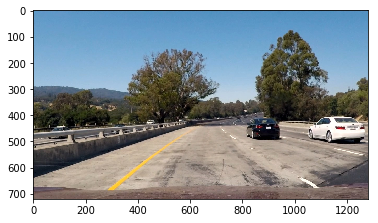

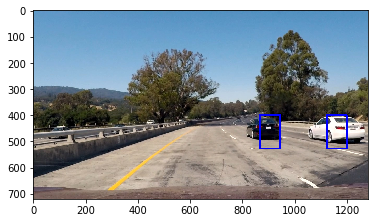

In [37]:
# load images
test_images = glob.glob('test_images/*')
image_bgr = cv2.imread(test_images[0])
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# run test image through pipeline
detected_image = detect_vehicles(image_bgr)

# show both images
plt.figure()
plt.imshow(image_rgb)

plt.figure()
plt.imshow(detected_image)

# VIDEO OUTPUT

In [ ]:
# create video
vid_output = 'output_images/output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detect_vehicles) 
%time white_clip.write_videofile(vid_output, audio=False)

In [ ]:
# # output video
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(vid_output))

In [ ]:
#####################
### HISTOGRAM VISUALIZATION ###
#####################

# # load images
# cutout_images = glob.glob('cutout_images/cars/*')
# img = cv2.imread(cutout_images[0])
# img = cv2.resize(img, (2560,2560))
# img = convert_color(img, convert='HSV')

# features = color_hist(img)
# plt.imshow(img)

# print(len(features))

# # channel1, channel2, channel3, bin_centers, feature_vector = color_hist(temp_img)

# # ## plot individual histograms ##
# # fig = plt.figure(figsize=(12,3))
# # plt.subplot(131)
# # plt.bar(bin_centers, channel1[0])
# # plt.xlim(0, 256)
# # plt.title('Channel 1 Histogram')
# # plt.subplot(132)
# # plt.bar(bin_centers, channel2[0])
# # plt.xlim(0, 256)
# # plt.title('Channel 2 Histogram')
# # plt.subplot(133)
# # plt.bar(bin_centers, channel3[0])
# # plt.xlim(0, 256)
# # plt.title('Channel 3 Histogram')
# # fig.tight_layout()


#####################
### SPATIAL BIN VISUALIZATION ###
#####################

# ## remove .ravel() in function

# cutout_images = glob.glob('cutout_images/cars/*')
# img = cv2.imread(cutout_images[0])

# features = bin_spatial(img, size=(64,64))
# print(len(features))

# # show image
# # plt.imshow(img)
# # plt.imshow(bin_spatial(img, size=(64,64)))


#####################
### HOG VISUALIZATION ###
#####################
    
# # load images
# template_images = glob.glob('cutout_images/cars/*')
# img = cv2.imread(template_images[3])

# # parameters for hog function
# orient = 10
# pix_cell = 6
# cell_block = 4

# # convert to gray
# gray = cv2.cvtColor(img_r, cv2.COLOR_RGB2GRAY)

# # get hog_features and hog_image
# hog_feat, hog_img = get_hog_features(gray, orient, pix_cell, cell_block, vis=True)

# # show images
# plt.figure()
# plt.imshow(img)

# plt.figure()
# plt.imshow(hog_img, cmap='gray')


#####################
### SLIDING WINDOW VISUALIZATION ###
#####################

# # load images
# test_images = glob.glob('test_images/*')
# img = cv2.imread(test_images[6])
# rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# # define windows
# windows = slide_windows(img, x_start_stop=x_bounds, y_start_stop=y_bounds, xy_window=window, xy_overlap=overlap)
# boxed_image = draw_boxes(rgb, windows)

# # show images
# plt.figure()
# plt.imshow(rgb)

# plt.figure()
# plt.imshow(boxed_image)

#####################
### HOT WINDOWS VISUALIZATION ###
#####################


# car_boxes = search_windows(img, windows, clf, X_scaler, orient, pix_per_cell, cell_per_block, color_space=cspace,\
#                            nbins=nbins, size=spatial_size, hog_channel=hog_channel,\
#                            hist_feat=hist_feat, spatial_feat=spatial_feat, hog_feat=hog_feat)
# detected_image = draw_boxes(rgb, car_boxes)
# plt.imshow(detected_image)

#####################
### HEAT MAP VISUALIZATION ###
#####################


# box_list = car_boxes # use car boxes from previous cell
# image = detected_image # use detected image from previous cell
# heatmap = np.zeros_like(image[:,:,0]).astype(np.float) # define heatmap

# # create heatmap
# heat = add_heat(heatmap, box_list)
# heat = heat_thresh(heat, 1)
# # create labels from heatmap
# labels = label(heatmap)
# print(labels[1], 'cars found')

# # find and draw box boundaries based on heat map
# heat_boxes = find_heat_boxes(image, labels)
# heatbox_image = draw_boxes(img, heat_boxes)

# plt.figure()
# plt.imshow(image)

# plt.figure()
# plt.imshow(heat, cmap='hot')

# plt.figure()
# plt.imshow(heatbox_image)